# PW2 - VAE for MNIST clustering and generation

In this practical, we will explore Variational Auto-Encoders (VAE) with the MNIST digit recognition dataset.
The purpose of a VAE is to generate new samples "looking like" the training samples.
For this purpose, we will construct a two-block model: encoder and decoder, one takes a sample and maps it to a latent space, the second takes a latent point and maps it to the sample space. If the latent distribution is roughly gaussian, this gives a way to get new samples: take a latent point at random,
and map it to the sample space with the decoder.

In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.utils import save_image

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib inline

from sklearn.metrics.cluster import normalized_mutual_info_score

In [2]:
N_CLASSES = 10
IMAGE_SIZE = 28 * 28

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [3]:
def show(img):
    plt.imshow(np.transpose(img.numpy(), (1,2,0)), interpolation='nearest')

def plot_reconstruction(model, n=24):
    x,_ = next(iter(data_loader))
    x = x[:n,:,:,:].to(device)
    try:
        out, _, _, log_p = model(x.view(-1, IMAGE_SIZE))
    except:
        out, _, _ = model(x.view(-1, IMAGE_SIZE))
    x_concat = torch.cat([x.view(-1, 1, 28, 28), out.view(-1, 1, 28, 28)], dim=3)
    out_grid = torchvision.utils.make_grid(x_concat).cpu().data
    show(out_grid)

@torch.no_grad()
def plot_generation(model, n=24):
    z = torch.randn(n, z_dim).to(device)
    out = model.decode(z).view(-1, 1, 28, 28)
    out_grid = torchvision.utils.make_grid(out).cpu()
    show(out_grid)

@torch.no_grad()
def plot_conditional_generation(model, n=8, fix_number=None):
    matrix = np.zeros((n, N_CLASSES))
    matrix[:,0] = 1

    if fix_number is None:
        final = matrix[:]
        for i in range(1, N_CLASSES):
            final = np.vstack((final,np.roll(matrix,i)))
        z = torch.randn(n, z_dim)
        z = z.repeat(N_CLASSES,1).to(device)
        y_onehot = torch.tensor(final).type(torch.FloatTensor).to(device)
        out = model.decode(z,y_onehot).view(-1, 1, 28, 28)
    else:
        z = torch.randn(n, z_dim).to(device)
        y_onehot = torch.tensor(np.roll(matrix, fix_number)).type(torch.FloatTensor).to(device)
        out = model.decode(z,y_onehot).view(-1, 1, 28, 28)

    out_grid = torchvision.utils.make_grid(out).cpu()
    show(out_grid)

@torch.no_grad()
def live_plot(data_dict, x_key=None, figsize=(7,5), title=''):
    clear_output(wait=True)
    plt.figure(figsize=figsize)
    for label, data in data_dict.items():
        if label == x_key or len(data) == 0:
            continue
        x = data_dict[x_key] if x_key is not None else np.arange(len(data))
        plt.plot(x, data, label=label, linewidth=1)
    plt.title(title)
    plt.grid(alpha=.5, which='both')
    plt.xlabel('epoch' if x_key is None else x_key)
    plt.legend(loc='center left') # the plot evolves to the right
    plt.show();

In [6]:
data_dir = './data'
dataset = torchvision.datasets.MNIST(
    root=data_dir,
    train=True,
    transform=transforms.ToTensor(),
    download=True)

data_loader = torch.utils.data.DataLoader(
    dataset=dataset,
    batch_size=128,
    shuffle=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(data_dir, train=False, download=True, transform=transforms.ToTensor()),
    batch_size=10, shuffle=False)

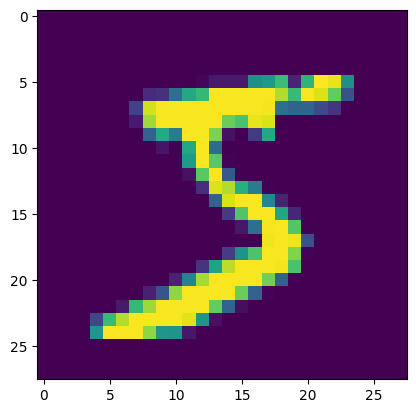

In [7]:
show(dataset[0][0])

# Part A - Variational Autoencoders

## A.1 - Autoencoding Theory

Consider a latent variable model with a data variable $x \in \mathcal{X}$ and a latent variable $z \in \mathcal{Z}$, with joint distribution $p(z,x) = p(z)p_\theta(x|z)$. Given the data $x_1,\dots,x_n$, we want to train the model by maximizing the marginal log-likelihood:

\[
\mathcal{L} = \mathbb{E}_{p_d(x)}\left[\log p_\theta(x)\right] = \mathbb{E}_{p_d(x)}\left[\log \int_{\mathcal{Z}} p_{\theta}(x|z)p(z)dz\right],
\]

where $p_d$ denotes the empirical distribution of $X$:  
$p_d(x) = \frac{1}{n}\sum_{i=1}^n \delta_{x_i}(x)$.

To avoid the (often) difficult computation of the integral above, the idea behind variational methods is to instead maximize a lower bound to the log-likelihood:

\[
\mathcal{L} \geq L(p_\theta(x|z), q(z|x)) = \mathbb{E}_{p_d(x)}\left[\mathbb{E}_{q(z|x)}\left[\log p_\theta(x|z)\right] - \mathrm{KL}\left(q(z|x) \,\|\, p(z)\right)\right].
\]

Any choice of $q(z|x)$ gives a valid lower bound. Variational Autoencoders replace the variational posterior $q(z|x)$ with an inference network $q_{\phi}(z|x)$ that is trained together with $p_{\theta}(x|z)$ to jointly maximize $L(p_\theta, q_\phi)$.

The variational posterior $q_{\phi}(z|x)$ is also called the **encoder**, and the generative model $p_{\theta}(x|z)$ is called the **decoder** or generator.

The first term, $\mathbb{E}_{q(z|x)}\left[\log p_\theta(x|z)\right]$, corresponds to the negative reconstruction error. Under a Gaussian assumption, i.e., $p_{\theta}(x|z) = \mathcal{N}(\mu_{\theta}(z), I)$, the term $\log p_\theta(x|z)$ reduces to $\propto \|x - \mu_\theta(z)\|^2$, which is often used in practice. The term $\mathrm{KL}\left(q(z|x)\,\|\,p(z)\right)$ acts as a regularization term, encouraging the variational posterior $q_\phi(z|x)$ to match the prior $p(z) = \mathcal{N}(0, I)$.

Variational Autoencoders were introduced by [Kingma and Welling (2013)](https://arxiv.org/abs/1312.6114); see also [Doersch (2016)](https://arxiv.org/abs/1606.05908) for a tutorial.

## A.2 - A Simple Autoencoder for MNIST

Implement the following autoencoder:

![A variational autoencoder.](https://github.com/dataflowr/notebooks/blob/master/HW3/vae.png?raw=true)

Add a ReLU activation after layers FC1 and FC4.

The outputs $\mu$ and $\log \sigma^2$ are used for reparameterization with:  
$z = \mu + \sigma \odot \epsilon$, where $\epsilon \sim \mathcal{N}(0,1)$.

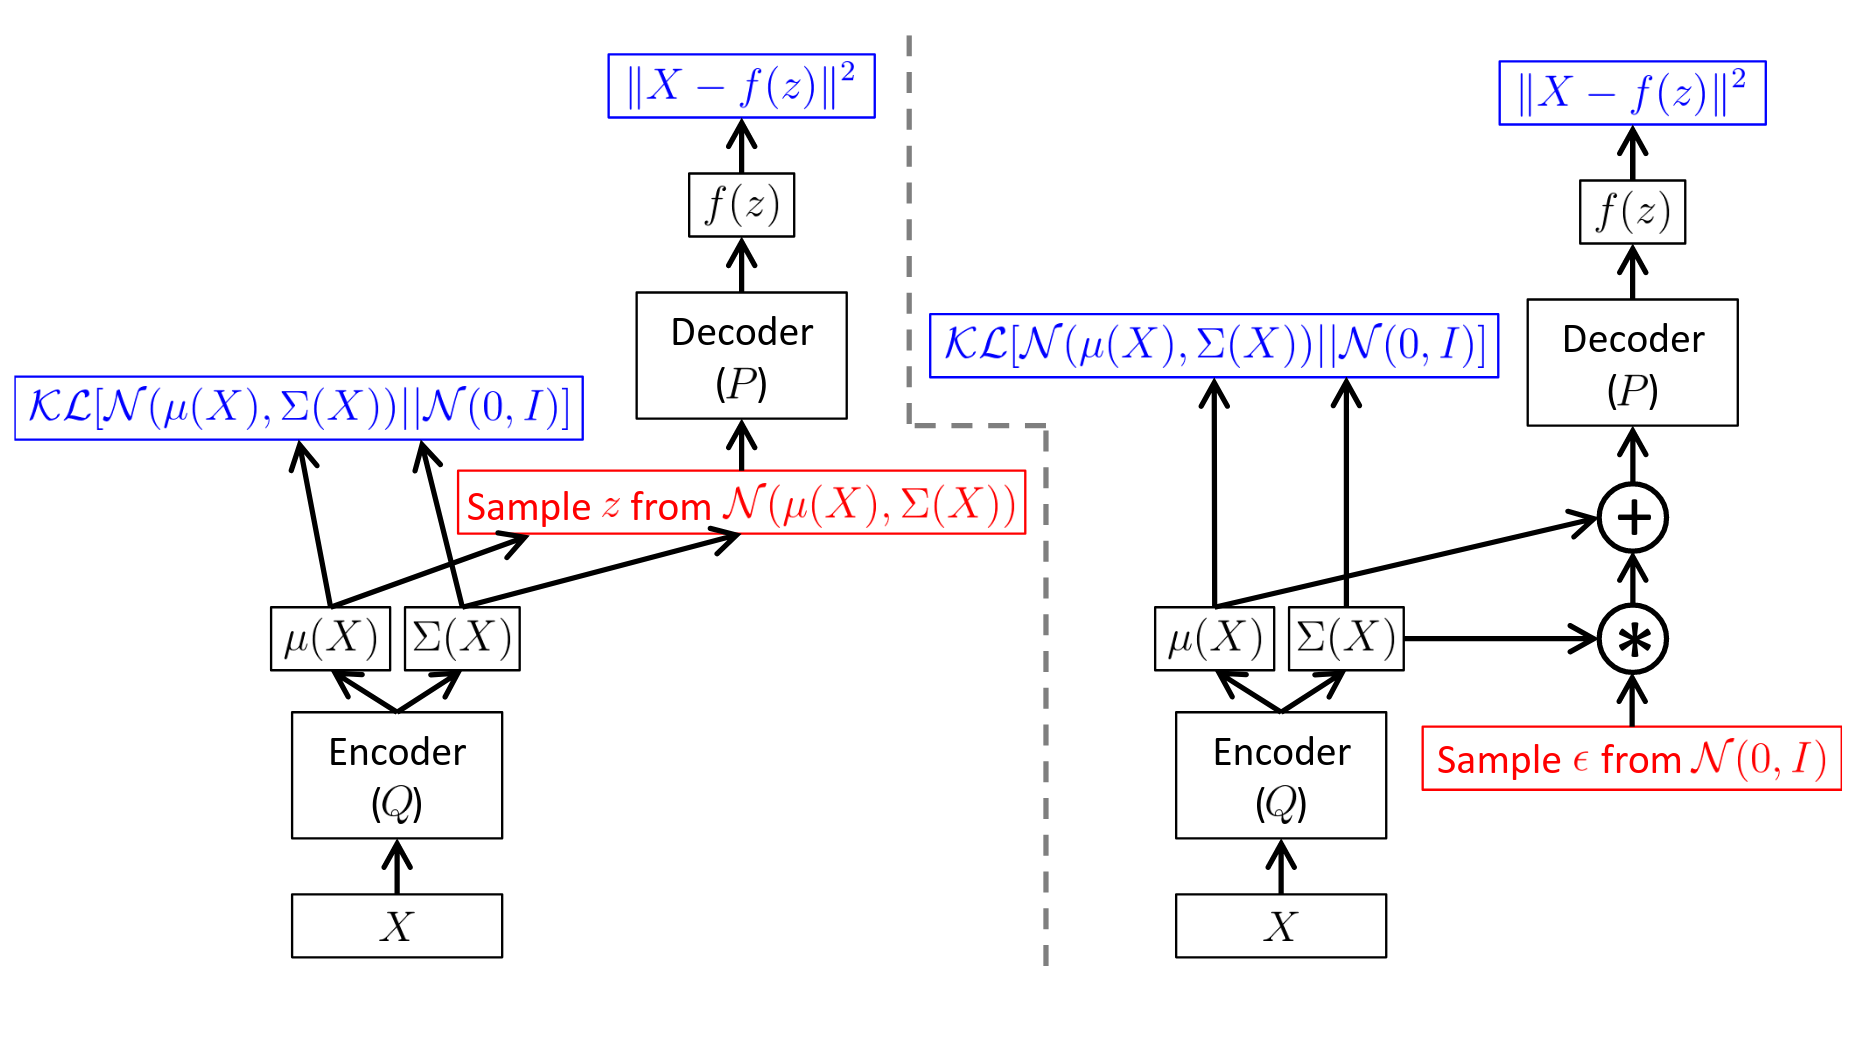

> Left: without the “reparameterization trick”.  
> Right: with it. Red indicates non-differentiable sampling operations.  
> Blue indicates loss layers. The feedforward behavior of these networks is identical, but backpropagation is only applicable to the right-hand version.


In [17]:
# VAE model
class VAE(nn.Module):
    def __init__(self, input_dim, h_dim, z_dim):
        super(VAE, self).__init__()

        self.z_dim = z_dim

        self.FC1 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dim, h_dim),
            nn.ReLU()
        )

        self.FC2 = nn.Sequential(
            nn.Linear(h_dim, z_dim)
        )

        self.FC3 = nn.Sequential(
            nn.Linear(h_dim, z_dim)
        )

        self.FC4 = nn.Sequential(
            nn.Linear(z_dim, h_dim),
            nn.ReLU(),
            nn.Linear(h_dim, input_dim),
            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.FC1(x)
        mu = self.FC2(x)
        log_var = self.FC3(x)
        return mu, log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        epsilon = torch.randn_like(std)
        return mu + epsilon * std

    def decode(self, z):
        z = self.FC4(z)
        return z

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        z = self.decode(z)
        return z, mu, log_var


# Hyper-parameters
h_dim = 400
z_dim = 20
num_epochs = 7
learning_rate = 1e-3

model = VAE(input_dim=28*28, h_dim=h_dim, z_dim=z_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Here for the loss, instead of MSE for the reconstruction loss, we take Binary Cross-Entropy (you should sum the loss over all pixels and samples, not average!)

The KL divergence can be computed as:

$$-\frac{1}{2} \sum_{j=1}^J\left(1+\log(\sigma_j^2) - \mu_j^2 -\sigma_j^2\right)$$

see Appendix B in VAE paper or (Doersch, 2016, https://arxiv.org/abs/1606.05908)

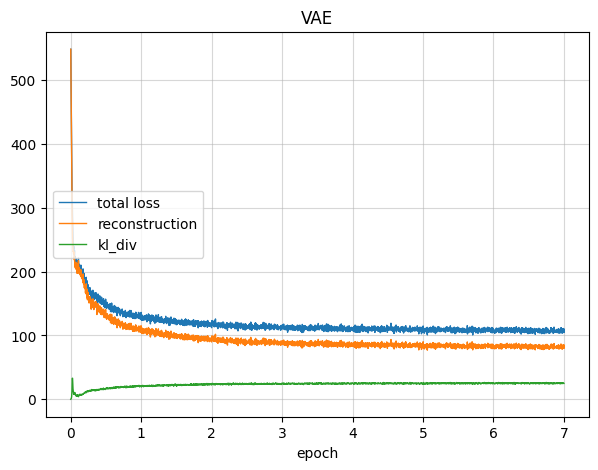

In [18]:
verbose = True
data_dict = { "epoch": [], "total loss": [], "reconstruction": [], "kl_div": [] }

for epoch in range(num_epochs):
    for i, (x, _) in enumerate(data_loader):
        # Forward pass
        x = x.to(device).view(-1, IMAGE_SIZE)
        x_reconst, mu, log_var = model(x)

        # Compute reconstruction loss and kl divergence
        reconst_loss = nn.functional.binary_cross_entropy(input=x_reconst, target=x, reduction="sum")
        kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        loss = reconst_loss + kl_div

        # Backprop and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Bookkeeping
        data_dict["total loss"].append(loss.item() / len(x))
        data_dict["reconstruction"].append(reconst_loss.item() / len(x))
        data_dict["kl_div"].append(kl_div.item() / len(x))
        data_dict["epoch"].append(epoch + float(1+i) / len(data_loader))


        if (i+1) % 100 == 0:
            if verbose:
                print ("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}"
                      .format(epoch+1, num_epochs, i+1, len(data_loader),
                              reconst_loss.item()/len(x), kl_div.item()/len(x)), end="\r")
            else:
                live_plot(data_dict, x_key="epoch", title="VAE")

live_plot(data_dict, x_key="epoch", title="VAE")

## A.3 - Evaluating results

Let us see how our network reconstructs our last batch. We display pairs of original digits and reconstructed version side by side.

Observe how most reconstructed digits are essentially identical to the original version.
This means that the identity mapping has been learned well.
You should still see some blurry digits very different from the original (resample a couple times if needed).

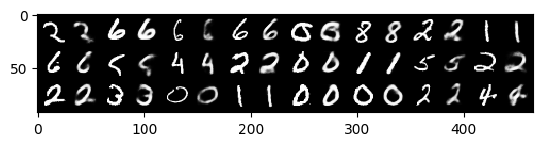

In [19]:
plot_reconstruction(model)

Let's see now how our network generates new samples.

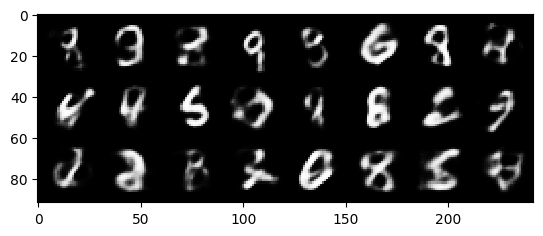

In [20]:
plot_generation(model)

Not great, but we did not train our network for long... That being said, we have no control of the generated digits. In the rest of this notebook, we explore ways to generates zeroes, ones, twos and so on.


As a by-product, we show how our VAE will allow us to do clustering thanks to the Gumbel VAE described below. But before that, we start by cheating a little bit...

# Part B - Cheating with the "conditional" VAE

We would like to generate samples of a given number. We have so far a model for images $X \in [0,1]^{P}$ with $P = 784$ pixels, generated as $X = f_\theta(Z)$ where $Z \sim \mathcal{N}(0,I)$ is a latent with normal distribution. In other to sample a specific digit, we will use a model
$g_\theta : \mathbb{R}^z \times \{0,\ldots,9\} \to [0,1]^P$ and sample images according to $X = g_\theta(Z, Y)$
where $Y \in \{0, \ldots, 9\}$ is a class label.

In the context of variational autoencoding, this is considered cheating,
because it uses external information (the class label) instead of learning the modes from the data.

To build the function $g$, we will simply concatenate the latent representation with
a one-hot encoding of the class. This way, we can use the above architecture with very little modification.

First, write a function transforming a label into its onehot encoding. This function will be used in the training loop (not in the architecture of the neural network!).

In [21]:
def l_2_onehot(labels, nb_digits=N_CLASSES):
    # take labels (from the dataloader) and return labels onehot-encoded
    ### your code here ###
    return nn.functional.one_hot(labels, nb_digits)

You can test it on a batch.

In [22]:
(x,labels) = next(iter(data_loader))

In [23]:
labels

tensor([2, 8, 0, 9, 3, 9, 2, 4, 9, 7, 5, 6, 7, 8, 9, 1, 2, 9, 1, 7, 0, 7, 8, 9,
        8, 3, 2, 1, 4, 0, 0, 8, 3, 3, 4, 1, 9, 4, 6, 1, 1, 4, 8, 5, 6, 3, 4, 7,
        8, 4, 5, 2, 0, 1, 5, 3, 2, 5, 2, 8, 8, 3, 3, 3, 0, 6, 0, 6, 5, 9, 8, 5,
        7, 7, 2, 0, 0, 9, 4, 2, 3, 0, 7, 8, 1, 7, 1, 3, 4, 2, 0, 4, 6, 0, 4, 7,
        4, 0, 1, 8, 7, 0, 0, 1, 8, 2, 3, 5, 8, 9, 9, 3, 8, 6, 6, 0, 6, 7, 5, 3,
        9, 8, 3, 4, 3, 7, 7, 6])

In [24]:
assert l_2_onehot(labels).shape == (*labels.shape, N_CLASSES)
l_2_onehot(labels)

tensor([[0, 0, 1,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 1, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])

Now modify the architecture of the VAE where the decoder takes as input the random code concatenated with the onehot encoding of the label, you can use `torch.cat`.

In [25]:
class VAE_Cond(nn.Module):
    def __init__(self, input_dim, h_dim, z_dim):
        super(VAE_Cond, self).__init__()
        ### your code here ###

        self.z_dim = z_dim

        self.FC1 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dim, h_dim),
            nn.ReLU()
        )
        self.FC2 = nn.Sequential(
            nn.Linear(h_dim, z_dim)
        )
        self.FC3 = nn.Sequential(
            nn.Linear(h_dim, z_dim)
        )
        self.FC4 = nn.Sequential(
            nn.Linear(z_dim + 10, h_dim),
            nn.ReLU(),
            nn.Linear(h_dim, input_dim),
            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.FC1(x)
        mu = self.FC2(x)
        log_var = self.FC3(x)
        return mu, log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        epsilon = torch.randn_like(std)
        return mu + epsilon * std

    def decode(self, z, l_onehot):
        z = torch.cat((z, l_onehot), dim=1)
        z = self.FC4(z)
        return z

    def forward(self, x, l_onehot):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        z = self.decode(z, l_onehot)

        return z, mu, log_var
        

Test your new model on a batch:

In [26]:
model_C = VAE_Cond(input_dim=28*28, h_dim=h_dim, z_dim=z_dim).to(device)
x = x.to(device).view(-1, IMAGE_SIZE)
l_onehot = l_2_onehot(labels).to(device)
x_reconst, mu, log_var = model_C(x, l_onehot)
assert x_reconst.shape == x.shape
assert mu.shape == log_var.shape and mu.shape == (x.shape[0], z_dim)
x_reconst.shape, mu.shape, log_var.shape

(torch.Size([128, 784]), torch.Size([128, 20]), torch.Size([128, 20]))

Now you can modify the training loop of your network. 

Also, scale the KL term in your loss with $\beta$ to strengthen the regularization as explained in the [$\beta$-VAE paper](https://openreview.net/forum?id=Sy2fzU9gl) see formula (4) in the paper.

In [27]:
def train_C(model, data_loader=data_loader,num_epochs=num_epochs, beta=20., verbose=True):
    nmi_scores = []
    model.train(True)
    data_dict = { "epoch": [], "total loss": [], "reconstruction": [], "kl_div": [] }
    title = "Conditional VAE"

    for epoch in range(num_epochs):
        for i, (x, labels) in enumerate(data_loader):
            x = x.to(device).view(-1, IMAGE_SIZE)

            ### your forward code here ###
            l_onehot = l_2_onehot(labels).to(device)
            x_reconst, mu, log_var = model_C(x, l_onehot)
            

            reconst_loss = nn.functional.binary_cross_entropy(input=x_reconst, target=x, reduction="sum")
            kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
            loss = reconst_loss + beta * kl_div

            # Backprop and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Bookkeeping
            data_dict["total loss"].append(loss.item() / len(x))
            data_dict["reconstruction"].append(reconst_loss.item() / len(x))
            data_dict["kl_div"].append(kl_div.item() / len(x))
            data_dict["epoch"].append(epoch + float(1+i) / len(data_loader))


            if (i+1) % 50 == 0:
                if verbose:
                    print("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}"
                           .format(epoch+1, num_epochs, i+1, len(data_loader),
                                   reconst_loss.item()/len(x),
                                   kl_div.item()/len(x)), end="\r")
                else:
                    live_plot(data_dict, x_key="epoch", title=title)

    live_plot(data_dict, x_key="epoch", title=title)

In [28]:
model_C = VAE_Cond(input_dim=28*28, h_dim=h_dim, z_dim=z_dim).to(device)
optimizer = torch.optim.Adam(model_C.parameters(), lr=learning_rate)

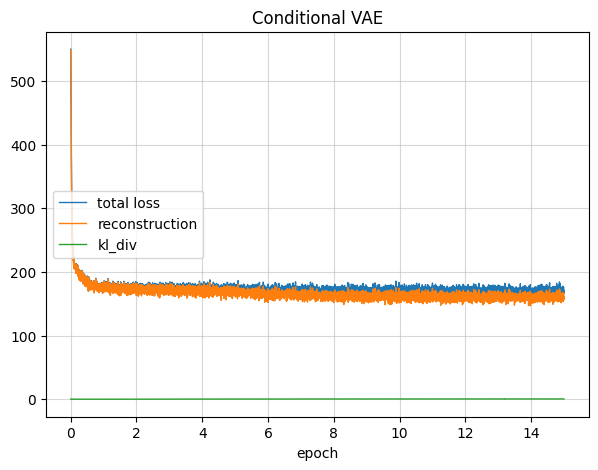

In [29]:
train_C(model_C, num_epochs=15, verbose=True)

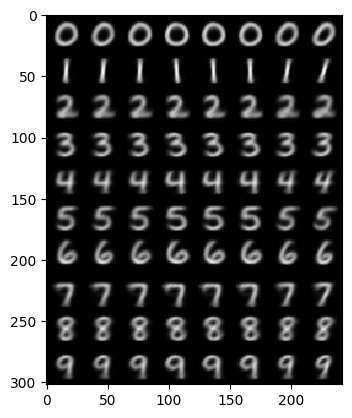

In [30]:
plot_conditional_generation(model_C)

Here you should get nice results. Now we will avoid the use of the labels...

# Part C - No cheating with Gumbel VAE

Implement a VAE where you add a categorical variable $c\in \{0,\dots 9\}$ so that your latent variable model is $p(c,z,x) = p(c)p(z)p_{\theta}(x|c,z)$ and your variational posterior is $q_{\phi}(c|x)q_{\phi}(z|x)$ as described in this NeurIPS paper: [(Dupont, 2018)](https://arxiv.org/abs/1804.00104). Try to make only minimal modifications to previous architecture.

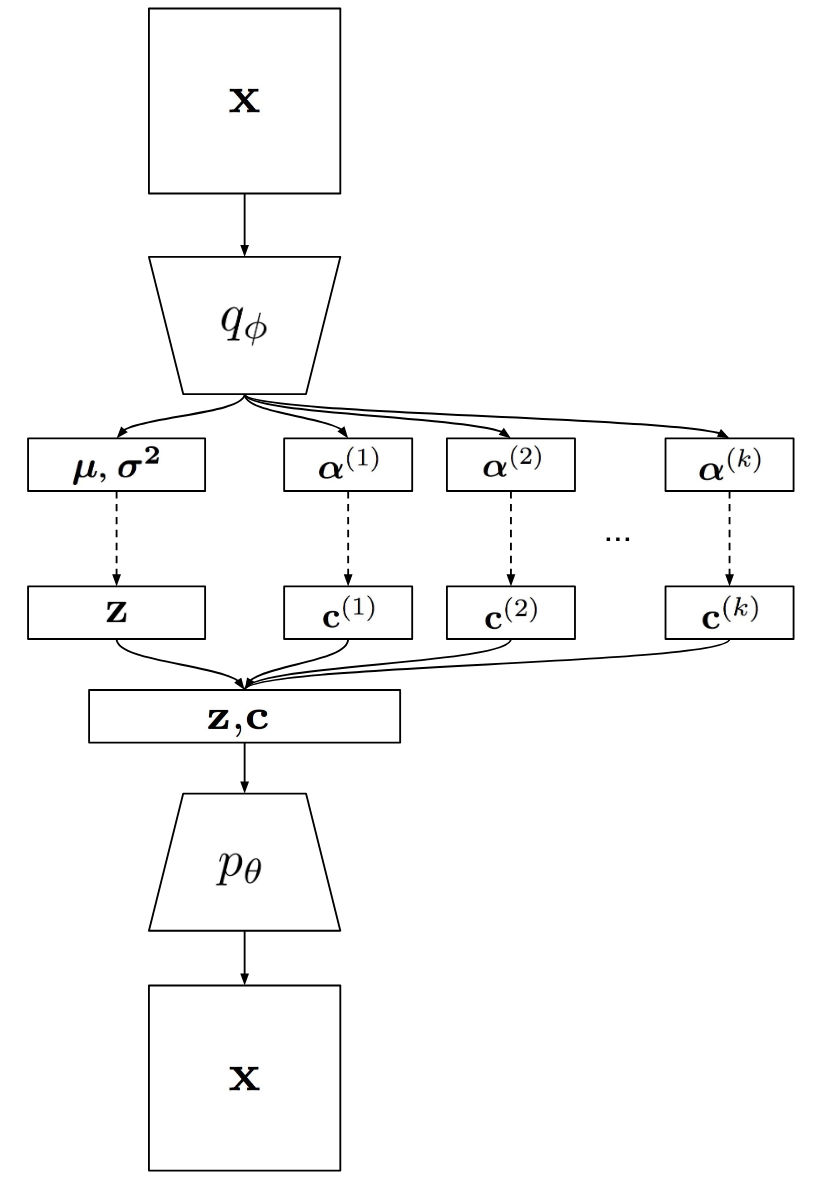

The idea is to incorporate a categorical variable in your latent space, without cheating by forcing it to take the value of the image's label. You hope that this categorical variable will encode the class of the digit, so that your network can use it for a better reconstruction, but can't force it. Moreover, if things work as planned, you will then be able to generate digits conditionally to the class, i.e. you can choose the class thanks to the latent categorical variable $c$ and then generate digits from this class.

## C.1 - Gumbel trick for discrete latent variables

As noticed above, in order to sample random variables while still being able to use backpropagation, we need to use the reparameterization trick which is easy for Gaussian random variables. For categorical random variables, the reparameterization trick is explained in [(Jang et al., 2016)](https://arxiv.org/abs/1611.01144). This is implemented in PyTorch thanks to [F.gumbel_softmax](https://pytorch.org/docs/stable/generated/torch.nn.functional.gumbel_softmax.html).

Note: there is an instability in the PyTorch `F.gumbel_softmax` implementation. We provide instead `gumbel_softmax` which takes the same arguments and ensures that the output is not NaN. If you encounter nans in your training or errors in the binary cross-entropy, make sure you are using the stabilized version.

Note: `gumbel_softmax` expects log-probabilities as input. See https://pytorch.org/docs/stable/generated/torch.nn.LogSoftmax.html

In [ ]:
def gumbel_softmax(logits, tau=1.0, hard=False, eps=1e-10, dim=-1):
    # type: (Tensor, float, bool, float, int) -> Tensor
    r"""
    This is a stabilized version of PyTorch's `F.gumbel_softmax`
    function, which samples zeros from the exponential and the
    nans when taking the logarithm.
    """

    def stabilized_gumbel():
        gumbels = - torch.empty_like(logits).exponential_().log()
        reject = torch.isnan(gumbels).sum() or torch.isinf(gumbels).sum()
        return stabilized_gumbel() if reject else gumbels

    gumbels = stabilized_gumbel()  # ~Gumbel(0,1)
    gumbels = (logits + gumbels) / tau  # ~Gumbel(logits,tau)
    y_soft = gumbels.softmax(dim)

    if hard:
        # Straight through.
        index = y_soft.max(dim, keepdim=True)[1]
        y_hard = torch.zeros_like(logits).scatter_(dim, index, 1.0)
        ret = y_hard - y_soft.detach() + y_soft
    else:
        # Reparametrization trick.
        ret = y_soft
    return ret
    
class VAE_Gumbel(nn.Module):
    def __init__(self, h_dim, z_dim, input_dim=28*28, num_classes=10, tau=1.0):
        super(VAE_Gumbel, self).__init__()
        self.z_dim = z_dim
        self.num_classes = num_classes
        self.tau = tau
        self.hard = False

        # Encoder
        self.FC1 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dim, h_dim),
            nn.ReLU()
        )
        self.FC2 = nn.Linear(h_dim, z_dim)  # Mean of z
        self.FC3 = nn.Linear(h_dim, z_dim)  # Log-variance of z
        self.FC4 = nn.Linear(h_dim, num_classes)  # Logits for categorical c

        # Decoder
        self.FC5 = nn.Sequential(
            nn.Linear(z_dim + num_classes, h_dim),
            nn.ReLU(),
            nn.Linear(h_dim, input_dim),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.FC1(x)
        mu = self.FC2(h)
        log_var = self.FC3(h)
        logits_c = self.FC4(h)
        return mu, log_var, logits_c

    def reparameterize_z(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        epsilon = torch.randn_like(std)
        return mu + epsilon * std

    def decode(self, z, y_onehot):
        latent = torch.cat((z, y_onehot), dim=1)
        return self.FC5(latent)

    def forward(self, x):
        mu, log_var, logits_c = self.encode(x)
        z = self.reparameterize_z(mu, log_var)
        y_onehot = gumbel_softmax(logits_c, tau=self.tau, hard=self.hard)
        x_reconst = self.decode(z, y_onehot)
        return x_reconst, mu, log_var, logits_c


You need to modify the loss to take into account the categorical random variable with an uniform prior on $\{0,\dots 9\}$, see Appendix A.2 in [(Dupont, 2018)](https://arxiv.org/abs/1804.00104).

Note this can be implemented by taking the entropy of $c$

In [151]:
def train_G(model, data_loader=data_loader,num_epochs=num_epochs, beta = 10., verbose=True):
    model.train(True)
    data_dict = {"epoch": [], "total loss": [], "reconstruction": [], "kl_div": [], "entropy": []}
    title = "Gumbel VAE"

    print("---- DEBUT OF TRAINING ----")
    print(f"Beta: {beta}, Tau: {model.tau}, Hard: {model.hard}, Epochs: {num_epochs}")

    for epoch in range(num_epochs):
        for i, (x, labels) in enumerate(data_loader):
            x = x.to(device).view(-1, IMAGE_SIZE)
            labels = labels.to(device)
            
            # Forward pass
            x_reconst, mu, log_var, logits_c = model(x)
            
            # Reconstruction loss (binary cross-entropy)
            reconst_loss = nn.functional.binary_cross_entropy(x_reconst, x, reduction="sum")
            
            # KL divergence for z
            kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
            
            # Entropy H(c) for the discrete latent variable c
            log_q_c = F.log_softmax(logits_c, dim=1)  # log of q(c)
            q_c = log_q_c.exp()
            entropy = -torch.sum(q_c * log_q_c)
            
            # Total loss
            loss = reconst_loss + beta * (kl_div + entropy)  # Note the positive sign on entropy
            
            # Backprop and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Bookkeeping
            data_dict["total loss"].append(loss.item() / len(x))
            data_dict["reconstruction"].append(reconst_loss.item() / len(x))
            data_dict["kl_div"].append(kl_div.item() / len(x))
            data_dict["entropy"].append(entropy.item())
            data_dict["epoch"].append(epoch + float(1+i) / len(data_loader))

            if (i+1) % 100 == 0:
                if verbose:
                    print(f"Epoch[{epoch+1}/{num_epochs}], Step [{i+1}/{len(data_loader)}], "
                        f"Reconst Loss: {reconst_loss.item()/len(x):.4f}, "
                        f"KL Div: {kl_div.item()/len(x):.4f}, Entropy: {entropy.item():.4f}", end="\r")

                else:
                    live_plot(data_dict, x_key="epoch", title=title)

    live_plot(data_dict, x_key="epoch", title=title)

In [152]:
model_G = VAE_Gumbel(h_dim=h_dim, z_dim=z_dim, tau=1.0).to(device)
model_G.hard = True
optimizer = torch.optim.Adam(model_G.parameters(), lr=learning_rate)

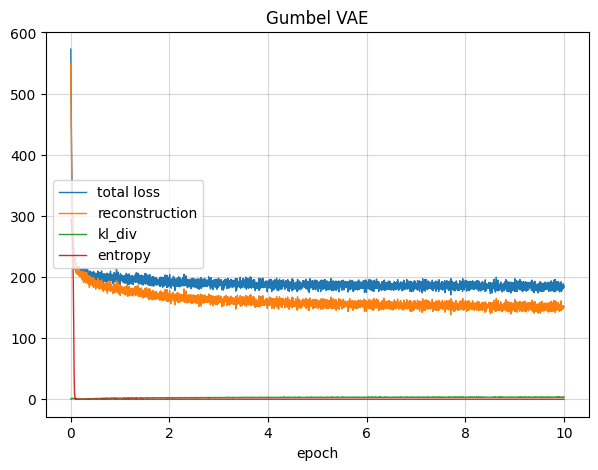

In [153]:
train_G(model_G, num_epochs=10, beta=10., verbose=True)

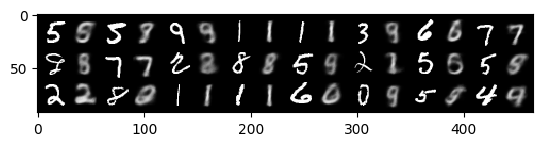

In [156]:
plot_reconstruction(model_G)

The reconstruction is good, but we care more about the generation. For each category, we generate 8 samples thanks to the `plot_conditional_generation()` function.
Consistently with the previous use, each row is supposed to consist of the same digit sampled 8 times, and each row should correspond to a distinct digit.

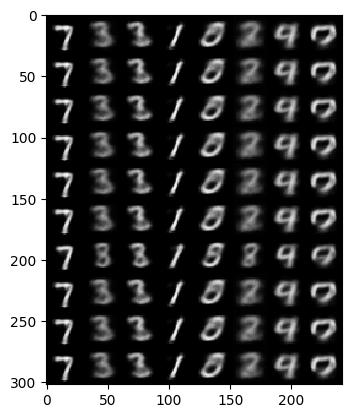

In [161]:
plot_conditional_generation(model_G)

It does not look like our original idea is working...

What is happening is that our network is not using the categorical variable at all (all "digits" look the same, the variation comes from the re-sampling of Z). We can track the [normalized mutual information](https://en.wikipedia.org/wiki/Mutual_information#Normalized_variants) (see [this method in scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.normalized_mutual_info_score.html)) between the true labels and the labels predicted by our network (just by taking the category with maximal probability).

Change your training loop to return the normalized mutual information (NMI) for each epoch. Plot the curve to check that the NMI is actually decreasing.

In [182]:
from sklearn.metrics import normalized_mutual_info_score


def train_G_bis(model, data_loader=data_loader, num_epochs=num_epochs, beta=20.0, hard=False, verbose=True):
    nmi_scores = []
    wpc_scores = []
    time_rec = []

    model.train(True)
    data_dict = {"epoch": [], "total loss": [], "reconstruction": [], "kl_div": [], "entropy": []}
    title = "Gumbel VAE with NMI"

    all_labels = []
    all_labels_est = []

    print("---- DEBUT OF TRAINING ----")
    print(f"Beta: {beta}, Tau: {model.tau}, Epochs: {num_epochs}")
    
    for epoch in range(num_epochs):
        all_labels.clear()
        all_labels_est.clear()
        s = time.time()

        for i, (x, labels) in enumerate(data_loader):
            x = x.to(device).view(-1, IMAGE_SIZE)
            labels = labels.to(device)
            
            # Forward pass
            x_reconst, mu, log_var, logits_c = model(x)
            
            # Reconstruction loss (binary cross-entropy)
            reconst_loss = nn.functional.binary_cross_entropy(x_reconst, x, reduction="sum")
            
            # KL divergence for z
            kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
            
            # Entropy H(c) for the discrete latent variable c
            log_q_c = F.log_softmax(logits_c, dim=1)  # log of q(c)
            q_c = log_q_c.exp()
            entropy = -torch.sum(q_c * log_q_c)
            
            # Total loss
            loss = reconst_loss + beta * (kl_div + entropy) 
            
            # Backprop and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Bookkeeping
            data_dict["total loss"].append(loss.item() / len(x))
            data_dict["reconstruction"].append(reconst_loss.item() / len(x))
            data_dict["kl_div"].append(kl_div.item() / len(x))
            data_dict["entropy"].append(entropy.item())
            data_dict["epoch"].append(epoch + float(1+i) / len(data_loader))
            
            # Collect labels for NMI calculation
            all_labels.extend(labels.cpu().numpy())
            all_labels_est.extend(q_c.argmax(dim=1).cpu().numpy())

            if (i+1) % 50 == 0:
                count = 0
                for a, b in zip(all_labels, all_labels_est):
                    if a == b:
                        count += 1
                        
                if verbose:
                    print(f"Epoch[{epoch+1}/{num_epochs}], Step [{i+1}/{len(data_loader)}], "
                        f"Reconst Loss: {reconst_loss.item()/len(x):.4f}, "
                        f"KL Div: {kl_div.item()/len(x):.4f}, Entropy: {entropy.item():.4f}, "+
                        f"Well pred cat.: [{100*round(count/len(all_labels),3):.1f}%]",end="\r")

                else:
                    live_plot(data_dict, x_key="epoch", title=title)

        nmi_epoch = 0
        nmi_epoch = normalized_mutual_info_score(all_labels, all_labels_est)
        nmi_scores.append(nmi_epoch)

        count = 0
        for a, b in zip(all_labels, all_labels_est):
            if a == b:
                count += 1

        wpc_scores.append(count/len(all_labels))

        # only computational time
        delta = round(time.time() - s,1)
        time_rec.append(delta)
        avg = np.mean(time_rec)
        min_d, sec_d = divmod(delta, 60)

        est_time = (avg+delta)/2 * (num_epochs - epoch - 1)
        min_e, sec_e = divmod(est_time, 60)

        print("  "*100, end="\r")
        print(f"Epoch {epoch + 1}, Tau: {model.tau:.2f}, NMI: {nmi_epoch:.4f}, WPC: {100*round(count/len(all_labels),3):.1f}%, "+
            f"Time of Epoch: {min_d:.0f} min {sec_d:.1f} sec --> Est. Time: {min_e:.0f} min {sec_e:.1f} sec", end="\n")

    live_plot(data_dict, x_key="epoch", title=title)
    return nmi_scores, wpc_scores



In [183]:
model_G_bis = VAE_Gumbel(h_dim=h_dim, z_dim=z_dim, tau=1.0).to(device)
optimizer = torch.optim.Adam(model_G_bis.parameters(), lr=learning_rate)

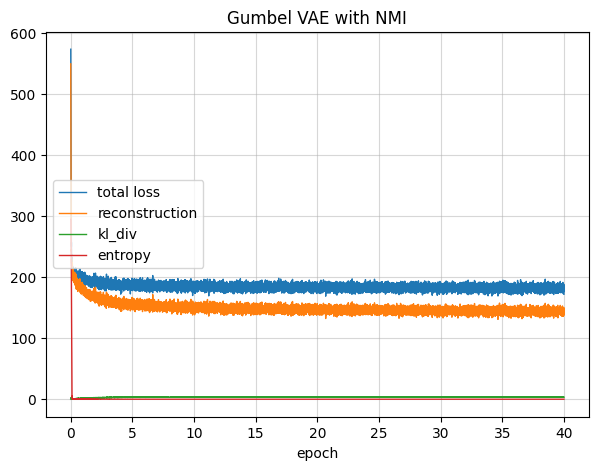

In [184]:
nmi_scores = train_G_bis(model_G_bis, num_epochs=40, beta=10, verbose=True)

In [190]:
len(nmi_scores)

2

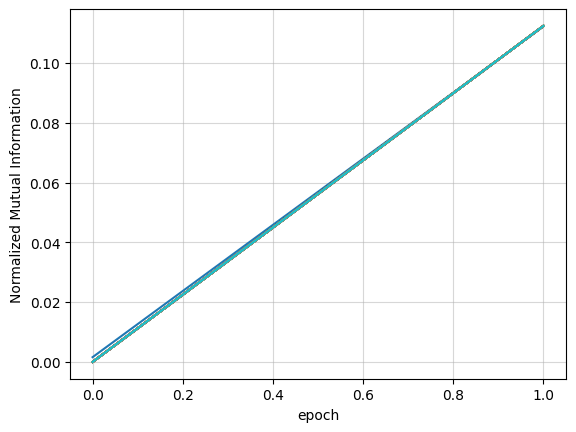

In [187]:
plt.plot(nmi_scores)
plt.xlabel("epoch")
plt.ylabel("Normalized Mutual Information")
plt.grid(alpha=.5, which='both')

## C.2 - Robust disentangling with controlled capacity increase

This problem is explained in [(Burgess et al., 2018)](https://arxiv.org/abs/1804.03599) and a solution is proposed in Section 5.

In order to force our network to use the categorical variable, we will change the loss according to [(Dupont, 2018)](https://arxiv.org/abs/1804.00104), Section 3 Equation (7).

Implement this change in the training loop and plot the new NMI curve. Increase the $C_z$ and $C_c$ constants by a constant value every epoch until it reaches the value passed in argument.
For $\beta = 20, C_z=100, C_c=100$, you should see that NMI increases.

In [ ]:
import time

def train_G_modified_loss(
    model,
    data_loader=data_loader,
    num_epochs=num_epochs,
    beta=1.,
    discount=1.0,
    C_z_fin=0,
    C_c_fin=0,
    verbose=True):

    nmi_scores = []
    wpc_scores = []
    time_rec = []

    model.train(True)
    data_dict = {"epoch": [], "total loss": [], "reconstruction": [], "kl_div_z": [], "entropy_c": []}
    title = "Gumbel VAE with NMI"
    all_labels = []
    all_labels_est = []

    print("---- DEBUT OF TRAINING ----")
    print(f"Beta: {beta}, Tau: {model.tau}, Epochs: {num_epochs}")

    for epoch in range(num_epochs):
        all_labels.clear()
        all_labels_est.clear()
        s = time.time()

        # on reste toujouts sur false
        if epoch < num_epochs * (5/4):
            model.hard = False
        else:
            model.hard = True

        for i, (x, labels) in enumerate(data_loader):
            x = x.to(device).view(-1, IMAGE_SIZE)
            labels = labels.to(device)
            
            # Forward pass
            x_reconst, mu, log_var, logits_c = model(x)
            
            # Reconstruction loss (binary cross-entropy)
            reconst_loss = nn.functional.binary_cross_entropy(x_reconst, x, reduction="sum")
            
            C_z = epoch * C_z_fin / (num_epochs - 1)
            C_c = epoch * C_c_fin / (num_epochs - 1)
        
            # KL divergence for z
            kl_div_z = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
            kl_div_z = torch.abs(kl_div_z - C_z) 

            # Entropy H(c) for the discrete latent variable c
            log_q_c = F.log_softmax(logits_c, dim=1)  # log of q(c)
            q_c = log_q_c.exp()
            entropy_c = -torch.sum(q_c * log_q_c)
            entropy_c = torch.abs(entropy_c - C_c)
            # Total loss
            loss = reconst_loss + beta * (kl_div_z + entropy_c) 
            
            # Backprop and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Bookkeeping
            data_dict["total loss"].append(loss.item() / len(x))
            data_dict["reconstruction"].append(reconst_loss.item() / len(x))
            data_dict["kl_div_z"].append(kl_div_z.item() / len(x))
            data_dict["entropy_c"].append(entropy_c.item() / len(x))
            data_dict["epoch"].append(epoch + float(1+i) / len(data_loader))
            
            # Collect labels for NMI calculation
            all_labels.extend(labels.cpu().numpy())
            all_labels_est.extend(q_c.argmax(dim=1).cpu().numpy())

            if (i+1) % 50 == 0 or i == len(data_loader):
                count = 0
                for a, b in zip(all_labels, all_labels_est):
                    if a == b:
                        count += 1
                nmi = normalized_mutual_info_score(all_labels, all_labels_est)
                if verbose:
                    print(f"Epoch[{epoch+1}/{num_epochs}], Step [{i+1}/{len(data_loader)}], "
                        f"Reconst Loss: {reconst_loss.item()/len(x):.4f}, "
                        f"KL Div: {kl_div_z.item()/len(x):.4f}, Entropy: {entropy_c.item():.4f}, "+
                        f"(WPD: [{100*round(count/len(all_labels),3):.1f}%], NMI: [{nmi:.4f}])",end="\r")

                else:
                    live_plot(data_dict, x_key="epoch", title=title)

        nmi_epoch = 0
        nmi_epoch = normalized_mutual_info_score(all_labels, all_labels_est)
        nmi_scores.append(nmi_epoch)

        count = 0
        for a, b in zip(all_labels, all_labels_est):
            if a == b:
                count += 1

        wpc_scores.append(count/len(all_labels))

        # only computational time
        delta = round(time.time() - s,1)
        time_rec.append(delta)
        avg = np.mean(time_rec)
        min_d, sec_d = divmod(delta, 60)
        est_time = (avg+delta)/2 * (num_epochs - epoch - 1)
        min_e, sec_e = divmod(est_time, 60)
        
        print("  "*100, end="\r")
        print(f"Epoch {epoch + 1}, (Tau: {model.tau:.2f}, Hard: {model.hard}), NMI: {nmi_epoch:.4f}, WPC: {100*round(count/len(all_labels),3):.1f}%, "+
            f"(Time of Epoch: {min_d:.0f} min {sec_d:.1f} sec --> Est. Time: {min_e:.0f} min {sec_e:.1f} sec)", end="\n")

        # Mise à jour du tau selon l'époque. On vise un tau > 1 au début puis < 1 à la fin
        model.tau = max(model.tau*discount, 0.8)

    live_plot(data_dict, x_key="epoch", title=title)

    return nmi_scores, wpc_scores

In [261]:
# Hyper-parameters
num_epochs = 40
learning_rate = 1e-2
beta = 20
C_z_fin = 100
C_c_fin = 100
discount = 1.0

model_G_ter = VAE_Gumbel(h_dim=h_dim, z_dim = z_dim, tau=1.0).to(device)
optimizer = torch.optim.Adam(model_G_ter.parameters(), lr=learning_rate)

nmi, wpc = train_G_modified_loss(
    model_G_ter, data_loader,
    num_epochs=num_epochs,
    beta=beta,
    C_z_fin=C_z_fin,
    C_c_fin=C_c_fin,
    discount=discount,
    verbose=True)

---- DEBUT OF TRAINING ----
Beta: 20, Tau: 1.0, Epochs: 40
Epoch 1, (Tau: 1.00, Hard: False), NMI: 0.0002, WPC: 10.0%, Time of Epoch: 0 min 31.3 sec --> Est. Time: 20 min 20.7 sec                                                                                
Epoch 2, (Tau: 1.00, Hard: False), NMI: 0.0854, WPC: 10.0%, Time of Epoch: 0 min 30.8 sec --> Est. Time: 19 min 35.2 sec                                                                                
Epoch 3, (Tau: 1.00, Hard: False), NMI: 0.1499, WPC: 11.0%, Time of Epoch: 0 min 33.0 sec --> Est. Time: 19 min 57.0 sec                                                                                
Epoch 4, (Tau: 1.00, Hard: False), NMI: 0.1586, WPC: 11.8%, Time of Epoch: 0 min 33.1 sec --> Est. Time: 19 min 32.7 sec                                                                                
Epoch 5, (Tau: 1.00, Hard: False), NMI: 0.1591, WPC: 11.8%, Time of Epoch: 0 min 32.9 sec --> Est. Time: 18 min 59.6 sec                 

KeyboardInterrupt: 

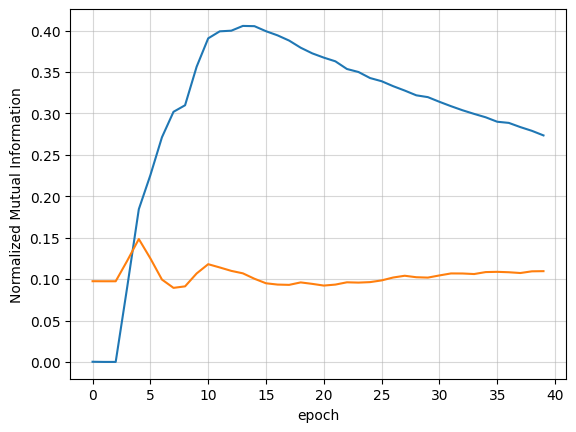

In [83]:
plt.plot(nmi)
plt.plot(wpc)
plt.xlabel("epoch")
plt.ylabel("Normalized Mutual Information")
plt.grid(alpha=.5, which='both')

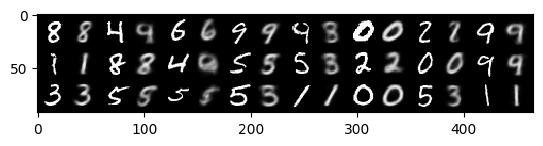

In [202]:
plot_reconstruction(model_G_ter)

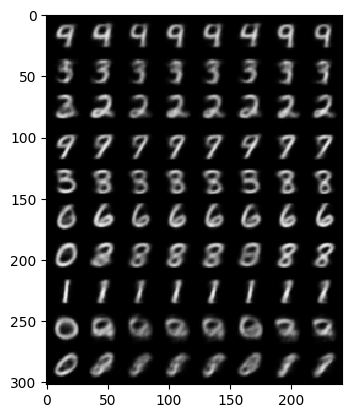

In [222]:
plot_conditional_generation(model_G_ter, fix_number=None)

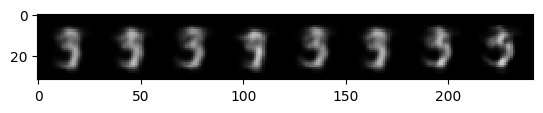

In [238]:
plot_conditional_generation(model_G_ter, fix_number=1)

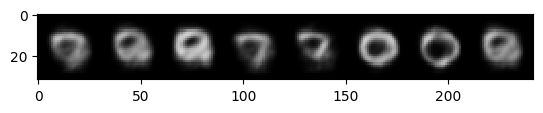

In [217]:
plot_conditional_generation(model_G_ter, fix_number=8)

## C.3 - Interpretation of learned results

Compare the generated digits from the Conditional VAE model and the modified Gumbel-VAE.
The conditional VAE produces all digits in order, which makes for a nice picture; on the other hand, the Gumbel VAE has no way of knowing the order of digits, it must just guess modes of pictures that look the same, so the order is meaningless.
Note however the variations of straight/inclined ones, are they present on the same row ?
What about shapes from the same row morphing from one digit to another, does it make sense that this was a considered a single mode by the model ? Are there distinct modes corresponding to the same digit, and if so, is it a reasonable distinction ?

In [ ]:
plot_conditional_generation(model_C, fix_number=None)

In [ ]:
plot_conditional_generation(model_G, fix_number=None)

---